In [76]:
import pandas as pd
df = pd.read_csv('data/DataScience and AI Jobs.csv')
pd.set_option('display.width', 1000)
df.head()

,title,location,summary,salary
0,newArtificial intelligence security specialist...,"Hyderabad, Telangana+1 location",An artificial intelligence (AI) specialist app...,NaN
1,newEDA Tool Developer,"Bengaluru, Karnataka",We are seeking highly motivated individuals wi...,NaN
2,Junior Project Engineer - Artificial Intellige...,"Pongumoodu, Thiruvananthapuram, Kerala",We are dedicated to providing quality and effe...,"₹15,000 - ₹25,000 a month"
3,Test Lead,"Noida, Uttar Pradesh",Working on over 18 different browser/os/ mobil...,NaN
4,+ Lead Testers,"Hyderabad, Telangana",Total Experience: 6- 8 yrs.\nAutomation Testin...,NaN


In [77]:
# Basic data overview
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1080 entries, 0 to 1079
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     1080 non-null   object
 1   location  1080 non-null   object
 2   summary   1080 non-null   object
 3   salary    230 non-null    object
dtypes: object(4)
memory usage: 33.9+ KB


We are interested in the title and salary columns

In [79]:
print(df.isnull().sum())
print(df['title'].nunique())

title         0
location      0
summary       0
salary      850
dtype: int64
['newArtificial intelligence security specialist (Senior)'
 'newEDA Tool Developer'
 'Junior Project Engineer - Artificial Intelligence / Machine...'
 'Test Lead' '+ Lead Testers'
 'Security Consultant: Intelligence & Operations' 'newBot Operator'
 'Internal Audit Specialist' 'Manager-Insights and Intelligence'
 'newSystems Integration Specialist' 'Technical Account Manager'
 'Software Engineer, Back End' 'Associate Consultant, Data Scientist'
 'Process Engineer' 'Computational Scientist' 'Computer Vision Engineer'
 'Machine Learning & Business Intelligence Analyst'
 'newProfessor, Associate Professor, Assistant Professor - School...'
 'Data Scientist: Artificial Intelligence' 'Software Engineer I'
 'Cloud Engineer Trainee' 'newAudit and Compliance Analyst'
 'Senior Analyst-Artificial Intelligence Innovation'
 'Artificial Intelligence & Machine Learning' 'newVBA Developer'
 'newLinux Development Engineer' 'Lea

The salary column is missing 850 values out of 1080  
The title column has almost 700 unique values

Here we will clean the title column to categorize the number of job titles.  
This cell performs the following steps to clean and categorize job titles in the dataset:

Standardize Titles: Convert all titles to lowercase and remove any leading or trailing whitespace for consistency.

Keyword Mapping: Replace job titles containing specific keywords with standardized titles.

Fuzzy Matching for AI/ML and Software Engineering: Use fuzzy matching to identify titles related to AI/ML and software engineering that may vary in wording. Titles with a similarity score above a specified threshold are mapped to "AI/ML" or "Software Engineer."

Assign Unmatched Titles: Titles that don’t fit into any predefined categories are assigned the label "Other."

In [80]:
# Standardize title column by converting to lowercase and removing whitespace
df['title'] = df['title'].str.lower().str.strip()

# Map specific keywords in titles to standard job categories
df.loc[df['title'].str.contains("data scien"), 'title'] = 'Data Scientist'
df.loc[df['title'].str.contains("data analyst"), 'title'] = 'Data Analyst'
df.loc[df['title'].str.contains("data engineer"), 'title'] = 'Data Engineer'
df.loc[df['title'].str.contains("developer"), 'title'] = 'Developer'
df.loc[df['title'].str.contains("qa"), 'title'] = 'Quality Assurance'
df.loc[df['title'].str.contains("analyst"), 'title'] = 'Data Analyst'
df.loc[df['title'].str.contains("manage"), 'title'] = 'Management'
df.loc[df['title'].str.contains("consultant"), 'title'] = 'Consultant'

from thefuzz import process
# Use fuzzy matching for AI/ML and software engineering titles
ai_roles = ['ai', 'ml', 'ai/ml', 'machine learning', 'artificial intelligence', 'nlp']

for role in ai_roles:
    matches = process.extract(role, df['title'], limit=df.shape[0])
    for match in matches:
        if match[1] > 75:
            df.loc[df['title'] == match[0], 'title'] = 'AI/ML'
            
matches = process.extract('software engineer', df['title'], limit=df.shape[0])
for match in matches:
    if match[1] > 80:
        df.loc[df['title'] == match[0], 'title'] = 'Software Engineer'

# Assign 'Other' to any titles not fitting identified categories
titles = ['Data Scientist', 'Data Analyst', 'Data Engineer', 'Developer', 'Software Engineer', 'AI/ML', 'Consultant']
df['title'] = df['title'].apply(lambda x: x if x in titles else 'Other')
# View counts of each standardized title
df['title'].value_counts()

title
Data Scientist       314
Other                279
Data Analyst         148
Developer            110
AI/ML                 95
Software Engineer     70
Data Engineer         40
Consultant            24
Name: count, dtype: int64

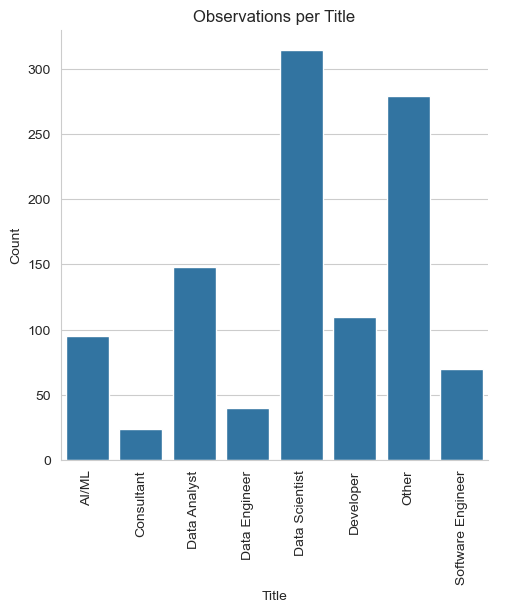

In [81]:
# Visualize the number observations in each title  
import seaborn as sns
import matplotlib.pyplot as plt
df = df.sort_values(by='title')
g = sns.catplot(x='title', data=df, kind='count')
g.set_xticklabels(rotation=90)
g.set(xlabel='Title', ylabel='Count', title='Observations per Title')
plt.show()

Here we will clean the salary column by doing the following operations:  
Remove Unwanted Characters: Strip out specific characters ('-', '₹', ',') and the phrase "a year" from salary entries.

Convert Salary Ranges to Midpoints: For entries that specify a salary range (e.g., "50000 60000"), the midpoint is calculated to represent an approximate value.

Standardize to Annual Salary: Converts all salaries to annual figures based on:

Monthly Salary: Multiplies by 12.
Daily Salary: Multiplies by 365.
Hourly Salary: Multiplies by 2080 (assuming a standard 40-hour work week).
Apply Conversion: The convert_to_yearly function is applied to each salary entry, resulting in a standardized annual salary column.

In [82]:
import re

# Remove unwanted characters (e.g., 'a year', '-', '₹', and commas) from salary values
s = ['a year', '-', '₹', ',']
pattern = '|'.join(map(re.escape, s))
df['salary'] = df['salary'].str.replace(pattern, '', regex=True)
df['salary'] = df['salary'].str.strip()

# Convert salary ranges to midpoints; single values are converted to floats
def convert_to_midpoint(value):
    if ' ' in value:
        lower, upper = map(float, value.split())
        return (lower + upper) / 2
    else:
        return float(value) 

# Convert all salary values to annual figures based on time units
def convert_to_yearly(value):
    value = str(value)
    if 'a month' in value:
        value = value.replace('a month', '').strip()  # Remove 'a month' and strip spaces
        return float(convert_to_midpoint(value)) * 12
    elif 'a day' in value:
        value = value.replace('a day', '').strip()  # Remove 'a day' and strip spaces
        return float(convert_to_midpoint(value)) * 365
    elif 'an hour' in value:
        value = value.replace('an hour', '').strip()  # Remove 'an hour' and strip spaces
        return float(convert_to_midpoint(value)) * 2080
    else:
        return convert_to_midpoint(value)

# Apply the yearly conversion to each salary
df['salary'] = df['salary'].apply(convert_to_yearly)
df['salary'].describe()

count    2.300000e+02
mean     8.721653e+05
std      7.286929e+05
min      6.000000e+04
25%      3.000000e+05
50%      6.950000e+05
75%      1.167286e+06
max      5.500000e+06
Name: salary, dtype: float64

In [83]:
# Check the number of missing salary values per title
missing_ratio = df['salary'].isna().groupby(df['title']).sum() / df['title'].value_counts()
print(missing_ratio)

title
AI/ML                0.694737
Consultant           1.000000
Data Analyst         0.804054
Data Engineer        0.850000
Data Scientist       0.783439
Developer            0.681818
Other                0.788530
Software Engineer    0.942857
dtype: float64


Each column has a high percentage of missing values, ranging from 68% to 100%.

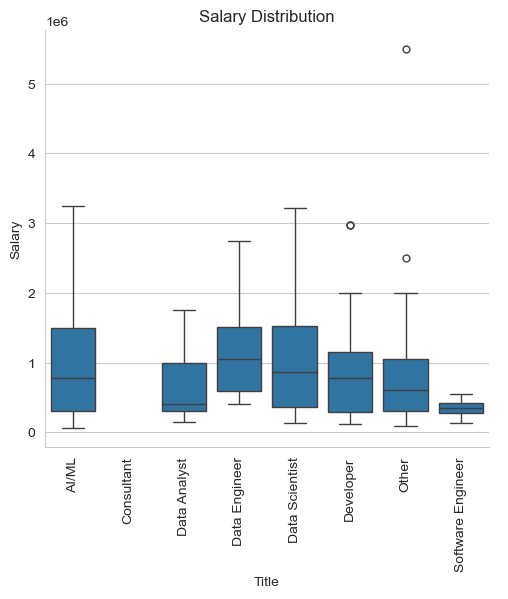

,count,mean,std,min,25%,50%,75%,max
title,,,,,,,,
AI/ML,29.0,1.016693e+06,825413.493806,60000.0,300000.0,780000.00,1500000.000,3250000.0
Consultant,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Data Analyst,29.0,6.594090e+05,472211.872888,150000.0,300000.0,405996.00,1000000.000,1750000.0
Data Engineer,6.0,1.224242e+06,873140.338284,400988.5,587500.0,1047230.75,1511115.375,2750000.0
Data Scientist,68.0,9.729034e+05,694281.211257,132000.0,360000.0,860000.00,1525000.000,3224000.0
Developer,35.0,8.422748e+05,710020.948560,120000.0,293868.0,784070.00,1150000.000,2976273.0
Other,59.0,8.072468e+05,811554.441986,84000.0,300000.0,600000.00,1050000.000,5500000.0
Software Engineer,4.0,3.452500e+05,169806.507531,138000.0,273000.0,346500.00,418750.000,550000.0


In [84]:
# Visualize the salary distribution for each job title.
g = sns.catplot(x='title', y='salary', data=df, kind='box')
g.set(xlabel='Title', ylabel='Salary', title='Salary Distribution')
g.set_xticklabels(rotation=90)
plt.show()

# Display summary statistics of the salary column by job title
df.groupby('title')['salary'].describe()

We will now impute missing salary values by filling them with the median salary for each job title  
Since there are no salary values available for the "Consultant" title, we will impute these missing values using the overall median salary from the dataset

In [85]:
salaries_dict = df.groupby('title')['salary'].median().to_dict()
median_salary = df['salary'].median()
df['salary'] = df['salary'].fillna(df['title'].map(salaries_dict))
df['salary'] = df['salary'].fillna(median_salary)

In [86]:
# Check to see if there are still any missing values
df['salary'].isna().groupby(df['title']).sum()

title
AI/ML                0
Consultant           0
Data Analyst         0
Data Engineer        0
Data Scientist       0
Developer            0
Other                0
Software Engineer    0
Name: salary, dtype: int64

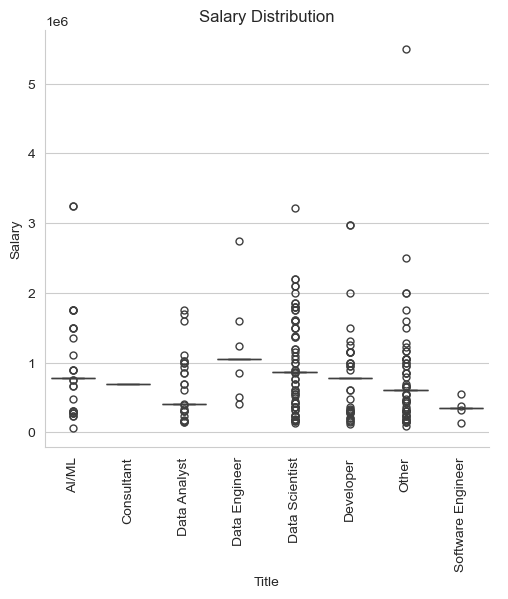

In [87]:
# Visualize the salary distribution for each job title.
g = sns.catplot(x='title', y='salary', data=df, kind='box')
g.set_xticklabels(rotation=90)
g.set(xlabel='Title', ylabel='Salary', title='Salary Distribution')
plt.show()

The salary distribution has shifted significantly. Given the high proportion of missing values, imputing with the median may not be the most effective solution. The current data is likely not representative of the true salary distribution.